In [3]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

**Problem 1:** Compute formula for the overlap area of two circles as a function
of their separation, b, and radius ratio, $k=R_p/R_*$.

**Problem 2:** Write a function to compute the transit/secondary eclipse of a
body without limb-darkening.

In [48]:
def longAngle(t, t0, P):
    """
    True longitude angle as a function of time [rad]
    t  : time array [days]
    t0 : time of inferior conjunction [days]
    P  : period [days]
    """
    return 2*math.pi/P*(t - t0)


def skySep(theta, a, i):
    """
    Compute projected sky separation btwn planet and star
    theta  : true longitude [rad]
    a      : orbital radius [Rs]
    i      : inclination angle [rad]
    """
    d = a * np.sqrt(np.cos(theta)**2 + np.cos(i)**2 * np.sin(theta)**2)
    return d

In [142]:
def blockedArea(d, k):
    """
    Compute fraction of blocked area during ingress/egress
    d  : sky separation btwn planet and star [Rs]
    k  : radius ratio Rp/Rs
    """
    u = (d**2 + 1 - k**2)/(2*d)
    v = (d**2 + k**2 - 1)/(2*d*k)
    
    A1 = np.arccos(u) - u*np.sqrt(1 - u**2)
    A2 = k**2*np.arccos(v) - k**2*v*np.sqrt(1 - v**2)
    
    return A1 + A2


def transitFlux(tarr, k, a, i, t0, P, F0=1):
    """
    Compute transit light curve as a function of time and orbital parameters
    t  : time array [days]
    k  : radius ratio Rp/Rs
    a  : orbital radius [Rs]
    i  : inclination angle [rad]
    t0 : time of inferior conjunction [days]
    P  : period [days]
    """
    model_flux = []
    
    for t in tarr:
        theta = longAngle(t, t0, P)
        d = skySep(theta, a, i)

        if 0 < theta  < math.pi:
            if (d > 1 + k):
                model_flux.append(F0)
            elif (d >= 1 - k) & (d <= 1 + k):
                model_flux.append(F0*(1 - blockedArea(d,k)/math.pi))
            elif (d < 1 - k):
                model_flux.append(F0*(1 - k**2))
        else:
            model_flux.append(F0)
    
    return np.array(model_flux)

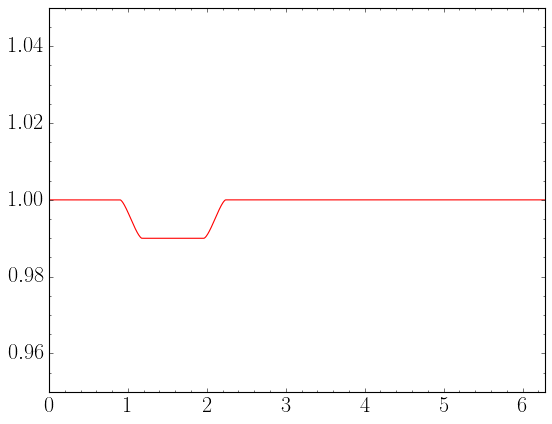

In [144]:
k, a, i, t0, P = .1, 1.5, math.pi/3, 0, 2*math.pi
tarr = np.linspace(0, P, 1e3)

model_flux = transitFlux(tarr, k, a, i, t0, P, F0=1)

plt.plot(tarr, model_flux, color='r')
plt.ylim(0.95,1.05)
plt.xlim(0,P)
plt.ticklabel_format(useOffset=False)
plt.minorticks_on()
plt.show()

**Problem 3:** Use your model to fit the data ‘mystery_planet02.txt’. What is the
period? What is the depth, impact parameter, and duration of this
transiting body? What is the density of the star?

In [117]:
data = pd.read_csv('files/mystery_planet02.txt', delim_whitespace=True, header=None)

time, flux, flux_err = np.array(data[0]), np.array(data[1]), np.array(data[2])

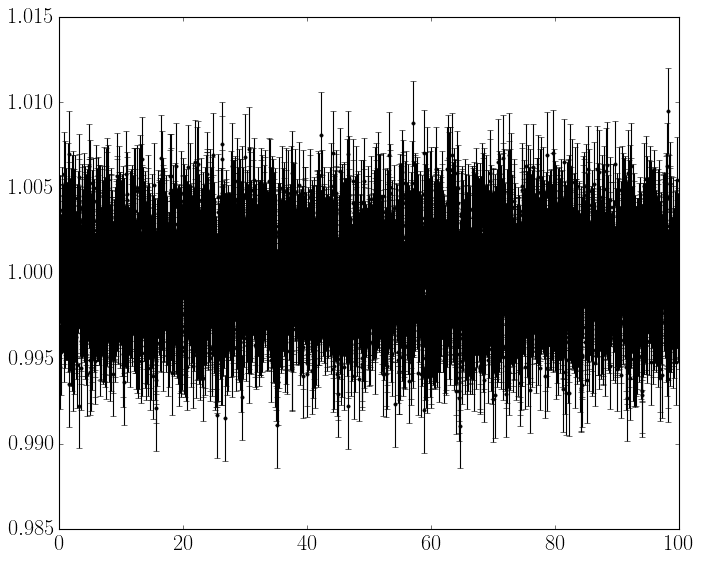

In [9]:
plt.figure(figsize=[10,8])
plt.errorbar(time, flux, yerr=flux_err, fmt='.', color='k')
plt.ticklabel_format(useOffset=False)
plt.show()

In [122]:
def phase_fold(time, flux, flux_err, P):
    
    fold = time % P
    phase_sort = np.argsort(fold)

    phase_time = fold[phase_sort]
    phase_flux = flux[phase_sort]
    phase_flux_err = flux_err[phase_sort]
    
    return phase_time, phase_flux, phase_flux_err

In [10]:
from astropy.timeseries import BoxLeastSquares
import astropy.units as u

In [119]:
model = BoxLeastSquares(time * u.day, flux, dy=flux_err)

periods = np.linspace(1, 50, 1e5) * u.day
periodogram = model.power(periods, 0.2)

best period: 9.793627936279362 d


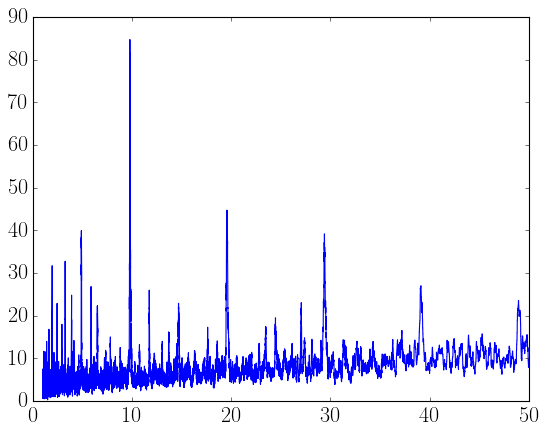

In [120]:
plt.plot(periodogram.period, periodogram.power);
print('best period:', periodogram.period[np.argmax(periodogram.power)])

In [185]:
def plot_lc_model(theta, data, P, **kwargs):
    k, a, i, t0 = theta
    phase_time, phase_flux, phase_flux_err = data
    
    tarr = np.linspace(0, P, 1e3)
    plot_model_flux = transitFlux(tarr, k, a, i, t0, P, F0=1)
    
    model_flux = transitFlux(phase_time, k, a, i, t0, P, F0=1)
    chi_val = np.sum(((phase_flux - model_flux)/phase_flux_err)**2)
    
    lbl = r'$k=%.3f, a=%.3f, i=%.3f, t_0=%.3f, P=%.3f$'%(k, a, i, t0, P)
    
    plt.figure(figsize=[20,8])
    plt.errorbar(phase_time, phase_flux, yerr=phase_flux_err, fmt='.', color='k', elinewidth=.3)
    plt.plot(tarr, plot_model_flux, color='r', linewidth=2, label=r'$\chi^2=%.3f$'%(chi_val))
    plt.text(P-.2, 1.0125, lbl, ha='right', fontsize=18)
    plt.xlim(0, P)
    plt.title('Transit Model Fit', fontsize=22)
    plt.xlabel('Phase [days]', fontsize=20)
    plt.ylabel(r'Normalized Flux', fontsize=20)
    plt.legend(loc='lower right')
    plt.ticklabel_format(useOffset=False)
    plt.minorticks_on()
    if 'save' in kwargs:
        plt.savefig(kwargs.get('save'))
    plt.show()

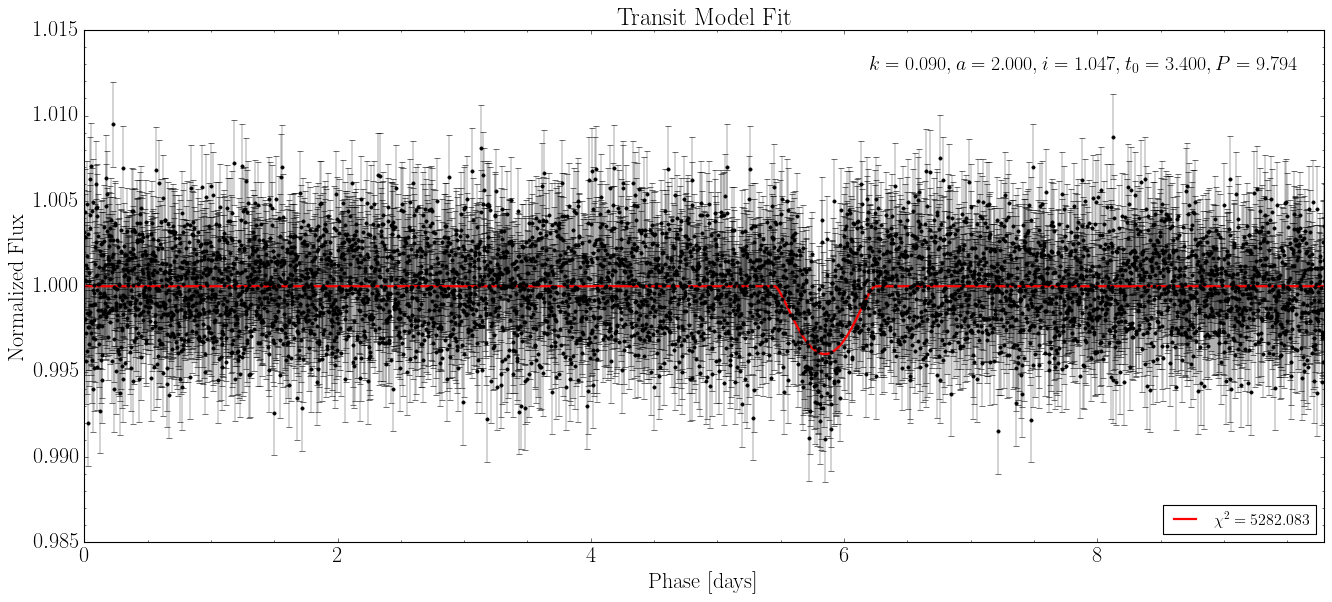

In [180]:
theta = [.09, 2, math.pi/3, 3.4]
data = phase_time, phase_flux, phase_flux_err

plot_lc_model(theta, data, best_period)

In [146]:
def log_likelihood(theta, data, P):
    """
    Assume Gaussian likelihood function
    theta : model parameters (k, a, i, t0, P)
    data  : phase-folded time, flux, flux_err
    P     : period, fixed during optimization
    """
    k, a, i, t0 = theta
    phase_time, phase_flux, phase_flux_err = data
    
    phase_flux_model = transitFlux(phase_time, k, a, i, t0, P)
    
    return -0.5 * np.sum((phase_flux - phase_flux_model)**2/phase_flux_err**2)

nll = lambda *args: -log_likelihood(*args)

In [147]:
initial = [k, a, i, t0]
bounds  = [(0,1), (1,5), (0,math.pi), (0,P)]
data    = [phase_time, phase_flux, phase_flux_err]

soln = minimize(nll, initial, method='TNC', bounds=bounds, args=(data, P))

In [148]:
print(soln)
print('initial:', initial)

     fun: 2567.9291970583204
     jac: array([-125.548695  ,   43.65833775, -231.3638106 ,  -47.19017852])
 message: 'Max. number of function evaluations reached'
    nfev: 100
     nit: 13
  status: 3
 success: False
       x: array([0.23045114, 2.23316104, 1.01278943, 3.35014125])
initial: [0.09, 2, 1.0471975511965976, 3.4]


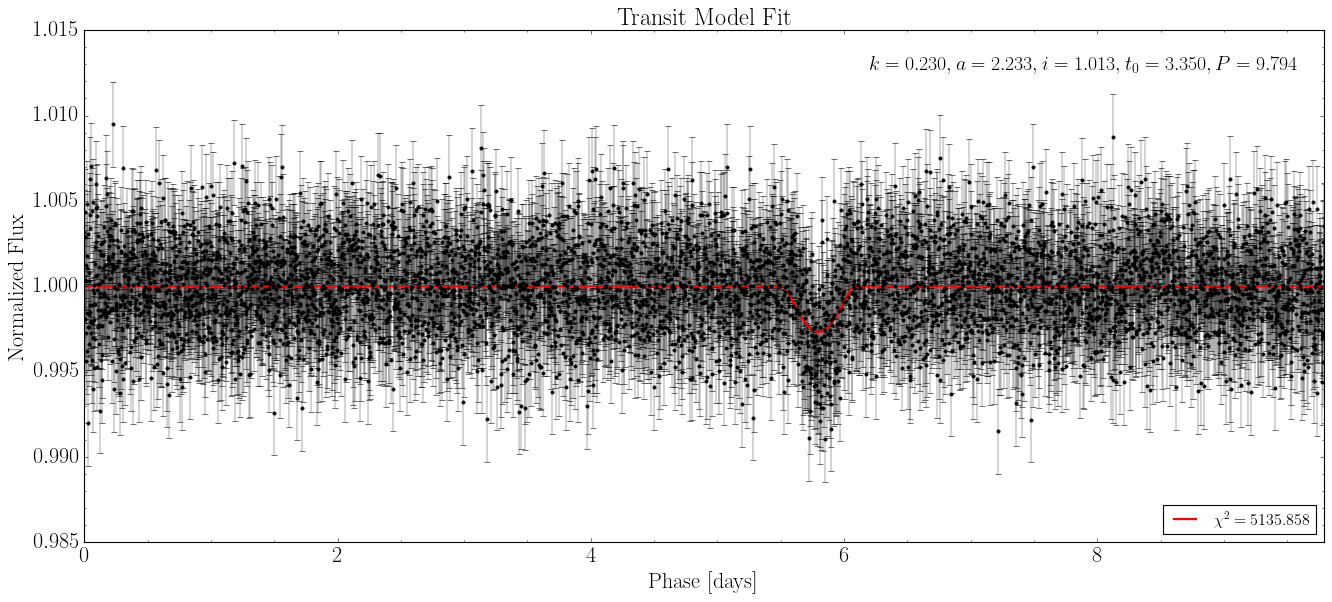

In [186]:
k_sol, a_sol, i_sol, t0_sol = soln.x
plot_lc_model(soln.x, data, best_period, save='transit_model_final.png')

**Extra Credit:** find the probability distribution of parameters
assuming a circular orbit

1.0471975511965976

In [206]:
flux_err

array([0.0025, 0.0025, 0.0025, ..., 0.0025, 0.0025, 0.0025])